In [1]:
from pathlib import Path
import sys
import pandas as pd
from PIL import Image
import io
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import time
from sklearn.model_selection import train_test_split
import torchvision 
from torchvision import transforms
import pickle
from scipy import stats
import numpy as np
from torchvision.models import efficientnet_b3
from torchcam.methods import SmoothGradCAMpp, CAM, GradCAMpp
from torchcam.utils import overlay_mask
from torchvision.transforms.functional import normalize, resize, to_pil_image
import torch.nn.functional as F
import math
import random

In [2]:
# Baseline
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        return x * self.se(x)
class EfficientNetB3(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True), 
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = SqueezeExcitation(40,10)
        self.model.features[1][1].block[1] = SqueezeExcitation(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = SqueezeExcitation(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = SqueezeExcitation(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = SqueezeExcitation(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = SqueezeExcitation(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = SqueezeExcitation(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = SqueezeExcitation(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = SqueezeExcitation(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = SqueezeExcitation(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = SqueezeExcitation(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = SqueezeExcitation(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = SqueezeExcitation(1392,58)
      self.model.features[7][1].block[2] = SqueezeExcitation(2304,96)
  def forward(self, x):
    return self.model(x)

In [3]:
# QAM
class QAM(nn.Module):
  def __init__(self, in_channels, reduction_dim):
    super(QAM, self).__init__()
    self.avgpool = nn.AdaptiveAvgPool2d((2,2))
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=reduction_dim, kernel_size=(1,1), stride=(1,1))
    self.conv2 = nn.Conv2d(in_channels=reduction_dim, out_channels=in_channels, kernel_size=(1,1), stride=(1,1))
    self.activation = nn.SiLU()
    self.scale_activation = nn.Sigmoid()
  def forward(self, x):
    residual = x.clone()
    b,c,h,w = x.size()
    x = self.avgpool(x)
    x = self.conv1(x)
    x = self.activation(x)
    x = self.conv2(x)
    x = self.scale_activation(x)
    # Apply scaling to the quadrants without additional cloning
    residual[:, :, 0:int(h/2), 0:int(w/2)] *= x[:, :, 0:1, 0:1]  # Top-left
    residual[:, :, 0:int(h/2), int(w/2):w] *= x[:, :, 0:1, 1:2]  # Top-right
    residual[:, :, int(h/2):h, 0:int(w/2)] *= x[:, :, 1:2, 0:1]  # Bottom-left
    residual[:, :, int(h/2):h, int(w/2):w] *= x[:, :, 1:2, 1:2]  # Bottom-right
    return residual


class EfficientNetB3QAM(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3QAM, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True), 
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = QAM(40,10)
        self.model.features[1][1].block[1] = QAM(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = QAM(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = QAM(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = QAM(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = QAM(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = QAM(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = QAM(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = QAM(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = QAM(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = QAM(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = QAM(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = QAM(1392,58)
      self.model.features[7][1].block[2] = QAM(2304,96)
  def forward(self, x):
    return self.model(x)

In [4]:
# HAM
class HAM(nn.Module):
  def __init__(self, in_channels, reduction_dim):
    super(HAM, self).__init__()
    self.global_avgpool =  nn.AdaptiveAvgPool2d((1,1))
    self.quadrant_avgpool = nn.AdaptiveAvgPool2d((2,2))
    self.fc = nn.Sequential(
            nn.Conv2d(in_channels, reduction_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduction_dim, in_channels, 1),
    )
    self.scale_activation = nn.Sigmoid()
  def forward(self, x):
    residual = x.clone()
    b,c,h,w = x.size()
    gap_out = self.fc(self.global_avgpool(x))
    qap_out = self.fc(self.quadrant_avgpool(x))
    x = self.scale_activation(self.scale_activation(gap_out) * qap_out)
    # Apply scaling to the quadrants without additional cloning
    residual[:, :, 0:int(h/2), 0:int(w/2)] *= x[:, :, 0:1, 0:1]  # Top-left
    residual[:, :, 0:int(h/2), int(w/2):w] *= x[:, :, 0:1, 1:2]  # Top-right
    residual[:, :, int(h/2):h, 0:int(w/2)] *= x[:, :, 1:2, 0:1]  # Bottom-left
    residual[:, :, int(h/2):h, int(w/2):w] *= x[:, :, 1:2, 1:2]  # Bottom-right
    return residual

class EfficientNetB3HAM(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3HAM, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),  # Dropout layer with 30% dropout rate
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)  # Adjust in_features to match EfficientNetB3 output
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = HAM(40,10)
        self.model.features[1][1].block[1] = HAM(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = HAM(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = HAM(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = HAM(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = HAM(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = HAM(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = HAM(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = HAM(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = HAM(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = HAM(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = HAM(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = HAM(1392,58)
      self.model.features[7][1].block[2] = HAM(2304,96)
  def forward(self, x):
    return self.model(x)

In [5]:
# credit: https://github.com/Peachypie98/CBAM/blob/main/cbam.py
class CAM(nn.Module):
    def __init__(self, channels, r=16):
        super(CAM, self).__init__()
        self.channels = channels
        self.r = r
        self.linear = nn.Sequential(
            nn.Linear(in_features=self.channels, out_features=self.channels//16, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=self.channels//16, out_features=self.channels, bias=True)
        )

    def forward(self, x):
        max = F.adaptive_max_pool2d(x, output_size=1)
        avg = F.adaptive_avg_pool2d(x, output_size=1)
        b, c, _, _ = x.size()
        linear_max = self.linear(max.view(b,c)).view(b, c, 1, 1)
        linear_avg = self.linear(avg.view(b,c)).view(b, c, 1, 1)
        output = linear_max + linear_avg
        return torch.sigmoid(output) * x
class EfficientNetB3CAM(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3CAM, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),  # Dropout layer with 30% dropout rate
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)  # Adjust in_features to match EfficientNetB3 output
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # CBAM in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = CAM(40,10)
        self.model.features[1][1].block[1] = CAM(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = CAM(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = CAM(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = CAM(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = CAM(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = CAM(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = CAM(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = CAM(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = CAM(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = CAM(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = CAM(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = CAM(1392,58)
      self.model.features[7][1].block[2] = CAM(2304,96)
  def forward(self, x):
    return self.model(x)

In [6]:
class ECA(nn.Module):
    def __init__(self, channels, b=1, gamma=2):
        super(ECA, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.channels = channels
        self.b = b
        self.gamma = gamma
        self.conv = nn.Conv1d(1, 1, kernel_size=self.kernel_size(), padding=(self.kernel_size() - 1) // 2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def kernel_size(self):
        k = int(abs((math.log2(self.channels)/self.gamma)+ self.b/self.gamma))
        out = k if k % 2 else k+1
        return out

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.conv(y.squeeze(-1).transpose(-1, -2)).transpose(-1, -2).unsqueeze(-1)
        y = self.sigmoid(y)
        return x * y.expand_as(x)
class EfficientNetB3ECA(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3ECA, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True), 
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = ECA(40)
        self.model.features[1][1].block[1] = ECA(24)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = ECA(144)
        for i in range(1,3):
          self.model.features[2][1].block[2] = ECA(192)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = ECA(192)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = ECA(288)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = ECA(288)
      for i in range(1,5):
        self.model.features[4][i].block[2] = ECA(576)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = ECA(576)
      for i in range(1,5):
        self.model.features[5][i].block[2] = ECA(816)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = ECA(816)
      for i in range(1,6):
        self.model.features[6][i].block[2] = ECA(1392)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = ECA(1392)
      self.model.features[7][1].block[2] = ECA(2304)
  def forward(self, x):
    return self.model(x)

In [7]:
class SqueezeExcitation(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SqueezeExcitation, self).__init__()
        self.se = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(in_channels, reduced_dim, 1),
            nn.SiLU(),
            nn.Conv2d(reduced_dim, in_channels, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return x * self.se(x)


# remove the max pooling idk why it is affecting the accuracy of both the cam and the sam
class SAM(nn.Module):
    def __init__(self, bias=True):
        super(SAM, self).__init__()
        self.bias = bias
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=7, stride=1, padding=3, dilation=1, bias=self.bias)

    def forward(self, x):
        avg_pool = torch.mean(x, 1, keepdim=True)
        output = self.conv(avg_pool)
        output = torch.sigmoid(output) * x  
        return output


class SESAM(nn.Module):
    def __init__(self, in_channels, reduced_dim):
        super(SESAM, self).__init__()
        self.se = SqueezeExcitation(in_channels, reduced_dim)
        self.sam = SAM()

    def forward(self, x):
        x = self.se(x)
        x = self.sam(x)
        return x

class EfficientNetB3SESAM(nn.Module):
  def __init__(self, num_classes, stages):
    super(EfficientNetB3SESAM, self).__init__()
    self.model = efficientnet_b3(weights="IMAGENET1K_V1", progress=True)
    self.model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True), 
        nn.Linear(in_features=1536, out_features=num_classes, bias=True)
    )
    for param in self.model.parameters():
        param.requires_grad = False
    for param in self.model.classifier.parameters():
        param.requires_grad = True
    # qse in stage 2
    if 2 in stages:
        self.model.features[1][0].block[1] = SESAM(40,10)
        self.model.features[1][1].block[1] = SESAM(24,6)
    # qse in stage 3
    if 3 in stages:
        self.model.features[2][0].block[2] = SESAM(144,6)
        for i in range(1,3):
          self.model.features[2][1].block[2] = SESAM(192,8)
    # qse in stage 4
    if 4 in stages:
      self.model.features[3][0].block[2] = SESAM(192,8)
      for i in range(1,3):  
        self.model.features[3][i].block[2] = SESAM(288,12)
    # qse in stage 5
    if 5 in stages:
      self.model.features[4][0].block[2] = SESAM(288,12)
      for i in range(1,5):
        self.model.features[4][i].block[2] = SESAM(576,24)
    # qse in stage 6
    if 6 in stages:
      self.model.features[5][0].block[2] = SESAM(576,24)
      for i in range(1,5):
        self.model.features[5][i].block[2] = SESAM(816,34)
    # qse in stage 7
    if 7 in stages:
      self.model.features[6][0].block[2] = SESAM(816,34)
      for i in range(1,6):
        self.model.features[6][i].block[2] = SESAM(1392,58)
    # qse in stage 8
    if 8 in stages:
      self.model.features[7][0].block[2] = SESAM(1392,58)
      self.model.features[7][1].block[2] = SESAM(2304,96)
  def forward(self, x):
    return self.model(x)

In [8]:
num_classes = 31
stages = [2,3,4,5,6,7,8]
model_baseline = EfficientNetB3(num_classes, stages).eval().cuda()
model_qam = EfficientNetB3QAM(num_classes, stages).eval().cuda()
model_ham = EfficientNetB3HAM(num_classes, stages).eval().cuda()
model_cam = EfficientNetB3CAM(num_classes, stages).eval().cuda()
model_eca = EfficientNetB3ECA(num_classes, stages).eval().cuda()
model_sesam = EfficientNetB3SESAM(num_classes, stages).eval().cuda()
models = {"baseline": model_baseline,
         "qam": model_qam,
         "ham": model_ham,
         "cam": model_cam,
         "eca": model_eca,
         "sesam": model_sesam   
}

In [9]:
models["baseline"].load_state_dict(torch.load("./index_and_weights/baseline.pth", weights_only=True))
models["qam"].load_state_dict(torch.load("./index_and_weights/qam.pth", weights_only=True))
models["ham"].load_state_dict(torch.load("./index_and_weights/ham.pth", weights_only=True))
models["cam"].load_state_dict(torch.load("./index_and_weights/cam.pth", weights_only=True))
models["eca"].load_state_dict(torch.load("./index_and_weights/eca.pth", weights_only=True))
models["sesam"].load_state_dict(torch.load("./index_and_weights/sesam.pth", weights_only=True))

<All keys matched successfully>

In [10]:
optimal_31_label = {
    0: "airplane",
    1: "airport",
    2: "baseball diamond",
    3: "basketball court",
    4: "beach",
    5: "bridge",
    6: "chaparral",
    7: "church",
    8: "circular farmland",
    9: "commercial area",
    10: "dense residential", 
    11: "desert",
    12: "forest", 
    13: "freeway",
    14: "golf course",
    15: "ground track field", 
    16: "harbor",
    17: "industrial area", 
    18: "intersection", 
    19: "island", 
    20: "lake",
    21: "meadow", 
    22: "medium residential", 
    23: "mobile home park",
    24: "mountain",
    25: "overpass",
    26: "parking lot", 
    27: "railway",
    28: "rectangular farmland",
    29: "roundabout",
    30: "runway"
}

In [11]:
df = pd.read_parquet("hf://datasets/jonathan-roberts1/Optimal-31/data/train-00000-of-00001-6f3929acf058ef6f.parquet")

In [12]:
df.head()

,image,label
0,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
1,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
2,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
3,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0
4,{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x...,0


In [13]:
def bytes_to_image(byte_data):
    image = Image.open(io.BytesIO(byte_data["bytes"]))  # Convert bytes to PIL image
    return image

df["image"] = df["image"].apply(bytes_to_image)
df.head()

,image,label
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0


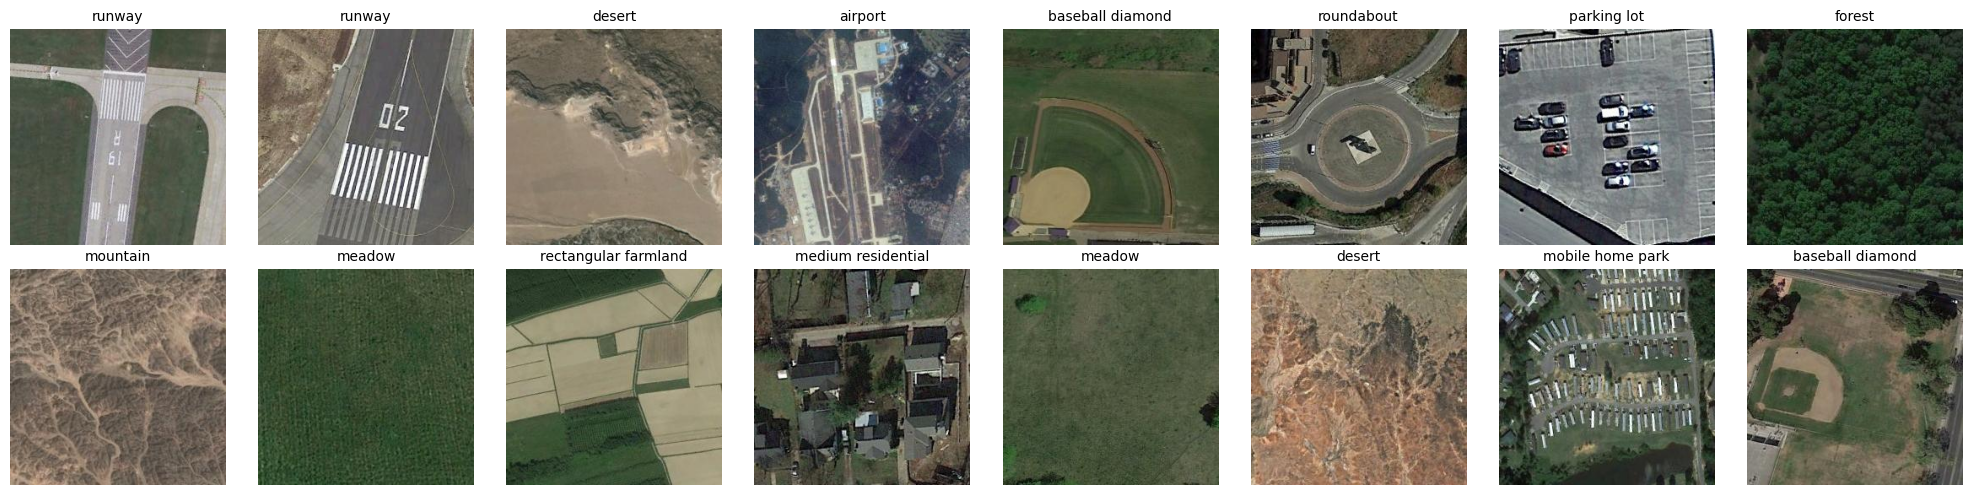

In [14]:
sampled_df = df.sample(n=16)
fig, axes = plt.subplots(2, 8, figsize=(20, 5))
axes = axes.ravel()
for i, (index, row) in enumerate(sampled_df.iterrows()):
    img = row['image']
    axes[i].imshow(img)
    axes[i].axis('off')
    axes[i].set_title(optimal_31_label[row['label']], fontsize=10)  
plt.tight_layout()
plt.show()

In [15]:
#img = df[df['label'] == 0].sample(n=1)["image"].values[0]
with open("./index_and_weights/val_indices.txt", "r") as f:
    val_indices = [int(line.strip()) for line in f]

# GradCAM

/tmp/ipykernel_2214981/3734005482.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  confidence = F.softmax(out).max().item()


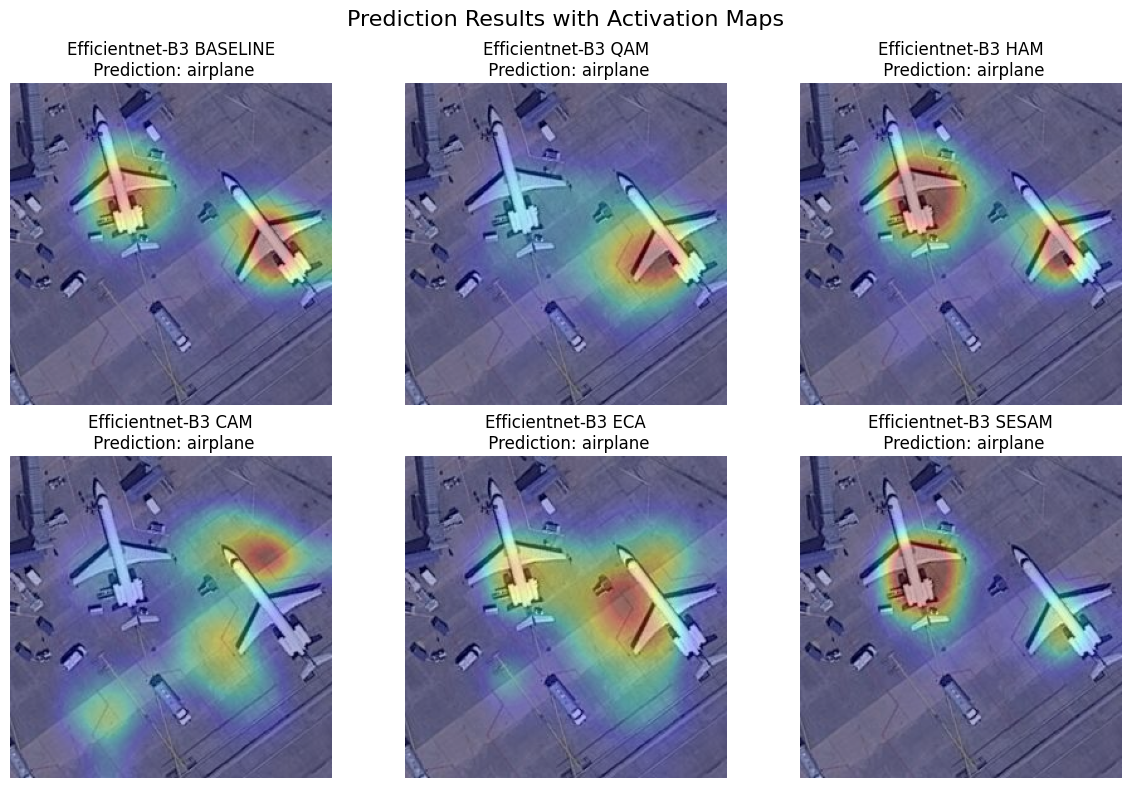

In [41]:
results = {"baseline": None,
           "qam": None,
           "ham": None,
           "cam": None,
           "eca": None,
           "sesam": None   
}

# random_index = random.choice(val_indices)
# # random_index = 1797
# img = df.loc[random_index]["image"]

df_val = df.loc[val_indices]
img = df_val[df_val['label'] == 0].sample(n=1)["image"].values[0]

resize = transforms.Resize((256, 256))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
input_tensor = normalize(to_tensor(resize(img))).cuda()

for index, (key, value) in enumerate(models.items()):
    with GradCAMpp(value, target_layer=value.model.features[-1]) as cam_extractor:
      # Preprocess your data and feed it to the model
        out = value(input_tensor.unsqueeze(0))
        # Retrieve the CAM by passing the class index and the model output
        activation_map = cam_extractor(out.squeeze(0).argmax().item(), out)
    prediction = optimal_31_label[out.squeeze(0).argmax().item()]
    confidence = F.softmax(out).max().item()
    overlay_image = overlay_mask(to_pil_image(to_tensor(img)), to_pil_image(activation_map[0].squeeze(0), mode='F'), alpha=0.7)
    results[key] = (prediction, confidence, overlay_image)
    #plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()


num_rows=2
num_cols=3
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
fig.suptitle("Prediction Results with Activation Maps", fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each activation map
for idx, (key, (prediction, confidence, overlay_image)) in enumerate(results.items()):
    axes[idx].imshow(overlay_image)
    axes[idx].axis("off")
    axes[idx].set_title(f"Efficientnet-B3 {key.upper()}\n Prediction: {prediction}", fontsize=12)

# Hide any unused subplots
for idx in range(len(results), num_rows * num_cols):
    axes[idx].axis("off")

plt.tight_layout()
plt.show()



    # Display it
    #plt.imshow(result); plt.axis('off'); plt.tight_layout(); plt.show()

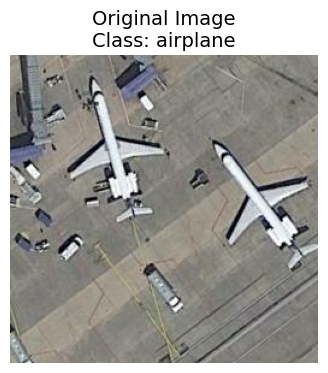

In [43]:
fig, ax = plt.subplots(figsize=(4, 4))  

# Display the image
ax.imshow(img)
ax.axis("off")  # Hide axis ticks

# Add title
ax.set_title(f"Original Image\nClass: airplane", fontsize=14)

# Show the plot
plt.show()

In [17]:
print(random_index)

165
